In [16]:
import spacy
from typing import Tuple, Dict
from collections import defaultdict
import pandas as pd
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

In [17]:
nlp = spacy.load('en_core_web_md')

PATH_TO_FOUR_CLASSES_DATA = './NRC-Sentiment-Emotion-Lexicons/' \
                            'NRC-Affect-Intensity-Lexicon/NRC-AffectIntensity-Lexicon.csv'

PATH_TO_EIGHT_CLASSES_DATA = './NRC-Sentiment-Emotion-Lexicons/' \
                             'NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.csv'

POS_MULTIPLIER = {'ADJ': 1, 'ADV': 0.8, 'VERB': 0.6, 'NOUN': 0.4}

# reading first dataset
four_classes = pd.read_csv(PATH_TO_FOUR_CLASSES_DATA, names=['token', 'score', 'label'], sep=r"\s+")
# reading second dataset
eight_classes = pd.read_csv(PATH_TO_EIGHT_CLASSES_DATA, names=['token', 'label', 'score'], sep=r"\s+")

In [18]:
# clean text
def clean_text(text: str) -> str:
    doc = nlp(text)
    # removing stop words and punctuation
    tokens = ' '.join(
        [re.sub('\n', '', token.text.lower()) for token in doc if not token.is_stop and not token.is_punct])
    return tokens

In [19]:
# normalization of each result
def scale_dict_result(dict_):
    values = dict_.values()
    min_ = min(values)
    max_ = max(values)
    return {key: ((v - min_) / (max_ - min_)) for (key, v) in dict_.items()}

In [20]:
def eval_text(text: str, dataset: pd.DataFrame, multiply: bool) -> Tuple:
    doc = nlp(text)
    emotional_class = defaultdict(list)
    result_dict = {}
    for token in doc:
        multiplier = 1
        if multiply:
            # part of speech
            pos = token.pos_
            try:
                multiplier = POS_MULTIPLIER[pos]
            except KeyError:
                continue
        sub_df = dataset.loc[dataset.token == token.text]
        if not sub_df.empty:
            for index, row in sub_df.iterrows():
                tmp = [row['token'], float(row['score'])*multiplier]
                if tmp not in emotional_class[row['label']]:
                    emotional_class[row['label']].append(tmp)
    if 'positive' in emotional_class:
        emotional_class.pop('positive')
        emotional_class.pop('negative')
    # probabilities calc
    s = 0
    for k, _ in emotional_class.items():
        result_dict[k] = sum(map(lambda x: x[1], emotional_class[k]))
        s += result_dict[k]
    for k, v in result_dict.items():
        result_dict[k] = v / s
    return emotional_class, result_dict


In [21]:
# load text
filename = 'sampleLove.txt'
file = open(filename, 'rt')
text = file.read()
file.close()


In [22]:
text = clean_text(text)
result1 = eval_text(text, four_classes, multiply=False)[1]
result2 = eval_text(text, eight_classes, multiply=True)[1]

# taking max values from each dataset, result2 is wider
aggregated_result = result2.copy()
for k, v in aggregated_result.items():
    if k in result1:
        aggregated_result[k] = max(result1[k], aggregated_result[k])

# labeling via min between emotional classes
labels = dict()
labels['high_positive'] = max([min(aggregated_result['joy'], aggregated_result['surprise']),
                               min(aggregated_result['joy'], aggregated_result['trust'])])
labels['positive'] = max([min(aggregated_result['joy'], aggregated_result['anticipation'])])
labels['neutral'] = max([min(aggregated_result['trust'], aggregated_result['anticipation']),
                         min(aggregated_result['surprise'], aggregated_result['anticipation'])])
labels['negative'] = max([min(aggregated_result['sadness'], aggregated_result['fear']),
                          min(aggregated_result['fear'], aggregated_result['anticipation'])])
labels['high_negative'] = max([min(aggregated_result['anger'], aggregated_result['disgust']),
                               min(aggregated_result['anger'], aggregated_result['fear']),
                               min(aggregated_result['disgust'], aggregated_result['fear'])])

In [23]:
display(labels)

{'high_positive': 0.0,
 'positive': 0.0,
 'neutral': 0.0,
 'negative': 0.0,
 'high_negative': 0.0}

In [24]:
from skfuzzy import trimf, trapmf
x = np.linspace(start = -1, stop = 1, num = 100)

In [25]:
m_functions = {}
m_functions['high_negative'] = trapmf(x, [-1, -1, -.8, -.2]) # high negative mem. function
m_functions['negative'] = trimf(x, [-.8, -0.2, 0]) # negative mem. function
m_functions['neutral'] = trimf(x, [-.2, 0, .2]) # neutral mem. function
m_functions['positive'] = trimf(x, [0, .2, .8]) # positive mem. function
m_functions['high_positive'] = trapmf(x, [.2, .8, 1, 1]) # high positive mem. function

In [26]:
mu_ = [m_functions[k] for k,_ in labels.items()]
mu_i = []
mu_i = [np.minimum(labels[k], m_functions[k]) for k,_ in labels.items()]
mu_s = np.max(mu_i, axis=0)
display(mu_s)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
display(mu_i)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 

In [29]:
# mass center calculation
y = np.trapz(x * mu_s, x=x) / np.trapz(mu_s, x=x)
display(y)

c:\users\sofij\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


nan

In [30]:
label = list(labels.keys())
#label.reverse()
display(label)

['high_positive', 'positive', 'neutral', 'negative', 'high_negative']

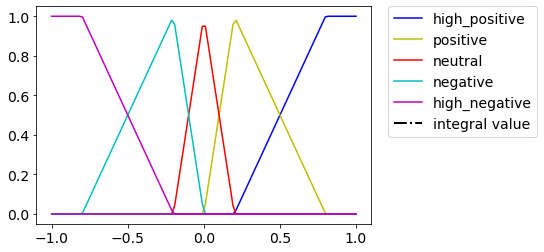

In [31]:
# ploting results
k = 0
colors = ['b', 'y', 'r', 'c', 'm']
for item in zip(mu_, mu_i):
    plt.plot(x, item[0], label=label[k], color=colors[k])
    plt.plot(x, item[1], color=colors[k])
    plt.fill_between(x, 0, item[1], facecolor='grey')
    k += 1
plt.axvline(x=y, ymin=0, ymax=1, color='black', linewidth=2, label='integral value', linestyle='-.')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)